In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint

In [79]:
df = pd.read_csv("../data/dfgeopoli.csv")

In [80]:
df.columns

Index(['Unnamed: 0', 'year', 'country_id_o', 'country_o', 'country_id_d',
       'country_d', 'contig', 'distcap', 'dist', 'comlang_off',
       'comlang_ethno', 'comrelig', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d',
       'gdpcap_o', 'gdpcap_d', 'fta_wto', 'tradeflow_comtrade_o',
       'tradeflow_comtrade_d', 'tradeflow_imf_o', 'tradeflow_imf_d',
       'IdealPointDistance', 'arms', 'tot_o', 'tot_d', 'tgdp_ratio_o',
       'tgdp_ratio_d', 'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o',
       'v2x_delibdem_o', 'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d',
       'v2x_partipdem_d', 'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports',
       'chemicalexports', 'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'log_tradeflow_comtrade_o',
       'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff',
     

In [81]:
X = df.dropna(subset=['gdpcap_d'])[['geodistance', 'distcap', 'gdpcap_d', 'pop_d']]
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df) # no large multicollinearity present

       Feature       VIF
0  geodistance  5.608730
1      distcap  5.288182
2     gdpcap_d  1.265124
3        pop_d  1.049985


### Creating lag values

In [82]:
# Sorting by (country_d, year)
df_2 = df.sort_values(by=['country_d', 'year'])

# Set lag variables
df_2['lag_pop_d'] = df_2.groupby('country_d')['pop_d'].shift(1)
df_2['lag_gdpcap_d'] = df_2.groupby('country_d')['gdpcap_d'].shift(1)

df_2 = df_2[df_2.groupby('country_d')['year'].diff() == 1]

df_2 = df_2.dropna(subset=['geodistance', 'lag_pop_d', 'lag_gdpcap_d', 'log_tradeflow_comtrade_o', 'log_tradeflow_comtrade_o'])

In [83]:
df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']].corrwith(df_2['log_tradeflow_comtrade_o'])

# makes sense, expect the signs of each variable

geodistance    -0.180455
distcap        -0.319656
lag_gdpcap_d    0.376160
lag_pop_d       0.326401
dtype: float64

In [84]:
# TimeSeriesSplit Cross-validation function
def timeseries_cv(model, X, y, folds = 6):
    tscv = TimeSeriesSplit(n_splits=folds) # around 5 years per fold, there are 32 years in total
    mse_list = []
    r2_list = []
    mae_list = []
    mape_list = []
    
    predictions = pd.Series(index=y.index, dtype=float)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        if hasattr(X, 'iloc'): # this is because some models uses the np, some uses pandas
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        if hasattr(y, 'iloc'): # this is because some models uses the np, some uses pandas
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        mae_list.append(mae)
        mape_list.append(mape)
        
        predictions.loc[y_test.index] = pd.Series(y_pred.flatten(), index=y_test.index)

    metrics = {
        'avg_mse': np.mean(mse_list), 
        'avg_r2': np.mean(r2_list), 
        'avg_mae': np.mean(mae_list), 
        'avg_mape': np.mean(mape_list),
        'folds': folds
    }

    return predictions, metrics

In [85]:
# Linear Regression
df_2 = df_2.sort_values(by=['year'])
linearX = df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']].copy()
linearY = df_2[['log_tradeflow_comtrade_o']].copy()

scaler = StandardScaler()
linearX = scaler.fit_transform(linearX)

linearModel = LinearRegression()

linearPredictions, linearMetrics = timeseries_cv(linearModel, linearX, linearY)
print(linearMetrics)

{'avg_mse': 5.322610258733652, 'avg_r2': 0.2568239805836335, 'avg_mae': 1.7073388573840227, 'avg_mape': 0.10061310598545979, 'folds': 6}


In [86]:
# XGBoost
xgboostX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
xgboostX['log_lag_pop_d'] = np.log1p(xgboostX['lag_pop_d'])
xgboostX['log_lag_gdpcap_d'] = np.log1p(xgboostX['lag_gdpcap_d'])

xgboostX = xgboostX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
xgboostY = df_2[['log_tradeflow_comtrade_o']]

# need to relook at the settings
xgboostModel = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

xgboostPredictions, xgboostMetrics = timeseries_cv(xgboostModel, xgboostX, xgboostY)
print(xgboostMetrics)

{'avg_mse': 1.9125371126414168, 'avg_r2': 0.7343794007577, 'avg_mae': 1.022296494134362, 'avg_mape': 0.062004416486577785, 'folds': 6}


In [87]:
# Hyperparameter tuning for XGBoost
tscv = TimeSeriesSplit(n_splits=6)

# Hyperparameter to try
xgboost_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# RandomizedSearchCV for hyperparameter tuning using tscv
xgboost_random_search = RandomizedSearchCV(
    estimator=xgboostModel,
    param_distributions=xgboost_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50 
)

xgboost_random_search.fit(xgboostX, xgboostY.values.ravel())

xgboost_best_params = xgboost_random_search.best_params_
xgboost_best_model = xgboost_random_search.best_estimator_

print(xgboost_best_params)
xgboostHPTpredictions, xgboostHPTmetrics = timeseries_cv(xgboost_best_model, xgboostX, xgboostY)
print(xgboostHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'colsample_bytree': 0.927891509969633, 'learning_rate': 0.1402721929311064, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.8048714736923235}
{'avg_mse': 1.4134897322382232, 'avg_r2': 0.797925427001692, 'avg_mae': 0.8449091603563438, 'avg_mape': 0.05112457716281663, 'folds': 6}


In [88]:
# Random forest regression
rfX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
rfX['log_lag_pop_d'] = np.log1p(rfX['lag_pop_d'])
rfX['log_lag_gdpcap_d'] = np.log1p(rfX['lag_gdpcap_d'])
rfX = rfX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
rfY = df_2['log_tradeflow_comtrade_o']

# base settings
rfModel = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=222)

rfPredictions, rfMetrics = timeseries_cv(rfModel, rfX, rfY)
print(rfMetrics)

{'avg_mse': 1.7017109631754124, 'avg_r2': 0.7610716368165811, 'avg_mae': 0.9184384459296521, 'avg_mape': 0.05627639598718531, 'folds': 6}


In [89]:
# Hyperparameter tuning for Random forest regression (similar to earlier)
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),  
}

rf_random_search = RandomizedSearchCV(
    estimator=rfModel,
    param_distributions=rf_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50 
)

rf_random_search.fit(xgboostX, xgboostY.values.ravel())
rf_best_params = rf_random_search.best_params_
rf_best_model = rf_random_search.best_estimator_

print(rf_best_params)
rfHPTpredictions, tfHPTmetrics = timeseries_cv(rf_best_model, rfX, rfY)
print(tfHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 86}
{'avg_mse': 1.7923977056867841, 'avg_r2': 0.7495285181391624, 'avg_mae': 0.9500842443505949, 'avg_mape': 0.0581930655162343, 'folds': 6}


In [90]:
# LightGBM
lgbmX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
lgbmX['log_lag_pop_d'] = np.log1p(lgbmX['lag_pop_d'])
lgbmX['log_lag_gdpcap_d'] = np.log1p(lgbmX['lag_gdpcap_d'])
lgbmX = lgbmX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
lgbmY = df_2[['log_tradeflow_comtrade_o']]

lgbmModel = LGBMRegressor(n_estimators=100, max_depth=10, random_state=222, verbosity = -1) # verbosity mutes output
lgbmPredictions, lgbmMetrics =  timeseries_cv(lgbmModel, lgbmX, lgbmY)
print(lgbmMetrics)

{'avg_mse': 1.4983589888959186, 'avg_r2': 0.7889163212119535, 'avg_mae': 0.8770780638623417, 'avg_mape': 0.053280390800892696, 'folds': 6}


In [91]:
# Hyperparameter tuning for LightGBM (similar to earlier)
lgbm_param_dist = {
    'n_estimators': randint(50, 200),           
    'max_depth': randint(3, 10),                
    'learning_rate': uniform(0.01, 0.2),        
    'num_leaves': randint(20, 100),           
}

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbmModel,
    param_distributions=lgbm_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50
)

lgbm_random_search.fit(lgbmX, lgbmY.values.ravel())
lgbm_best_params = lgbm_random_search.best_params_
lgbm_best_model = lgbm_random_search.best_estimator_

print(lgbm_best_params)
lgbmHPTpredictions, lgbmHPTmetrics = timeseries_cv(lgbm_best_model, lgbmX, lgbmY)
print(lgbmHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'learning_rate': 0.16992807150263953, 'max_depth': 9, 'n_estimators': 180, 'num_leaves': 43}
{'avg_mse': 1.4093682952089537, 'avg_r2': 0.8001254565505622, 'avg_mae': 0.8446686235333969, 'avg_mape': 0.05130710805589068, 'folds': 6}


In [92]:
df_results = df_2[['country_d', 'log_tradeflow_comtrade_o', 'year']].copy()
df_results['linearPrediction'] = linearPredictions
df_results['xgboostHPTPrediction'] = xgboostHPTpredictions
df_results['rfHPTPrediction'] = rfHPTpredictions
df_results['lgbmHPTPrediction'] = lgbmHPTpredictions

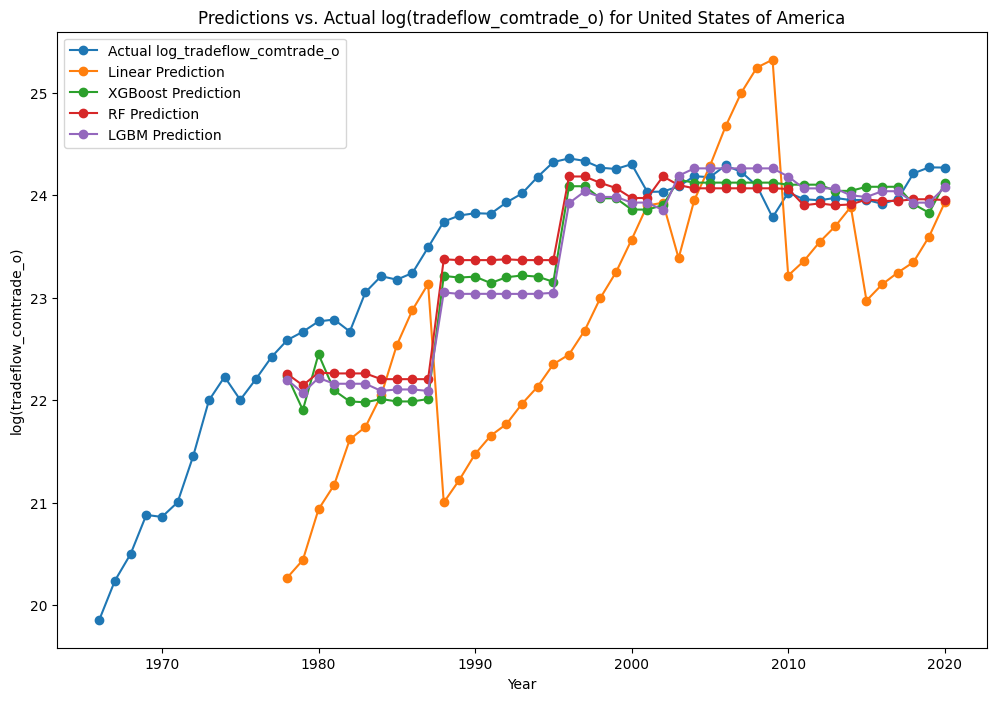

In [93]:
df_filtered = df_results[df_results['country_d'] == 'United States of America']

plt.figure(figsize=(12, 8))
plt.plot(df_filtered['year'], df_filtered['log_tradeflow_comtrade_o'], label='Actual log_tradeflow_comtrade_o', marker='o')
plt.plot(df_filtered['year'], df_filtered['linearPrediction'], label='Linear Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['xgboostHPTPrediction'], label='XGBoost Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['rfHPTPrediction'], label='RF Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['lgbmHPTPrediction'], label='LGBM Prediction', marker='o')

# Label the plot
plt.xlabel('Year')
plt.ylabel('log(tradeflow_comtrade_o)')
plt.title('Predictions vs. Actual log(tradeflow_comtrade_o) for United States of America')
plt.legend()
plt.show()

In [94]:
selected_cols = [
    'year', 'country_id_o', 'country_o', 'country_id_d',
    'country_d', 'contig', 'distcap', 'dist', 'comlang_off',
    'comlang_ethno', 'comrelig', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d',
    'gdpcap_o', 'gdpcap_d', 'fta_wto', 'tradeflow_comtrade_o', 'IdealPointDistance',
    'arms', 'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff',
    'v2x_delibdem_diff', 'v2x_egaldem_diff', 'geodistance'
]

df_last = df_2[selected_cols].copy()
df_last['Predicted'] = np.exp(xgboostHPTpredictions)

NameError: name 'x' is not defined

In [61]:
df_last[['gdpcap_d']]

,gdpcap_d
5,0.159
6,0.162
7,0.137
8,0.145
9,0.176
...,...
8385,1.009
8386,1.235
8387,1.255
8388,1.317


In [76]:
df_prediction = df_last[df_last['year'] == 2020][
    ['country_id_d', 'country_d', 'distcap', 'geodistance', 'gdpcap_d', 'pop_d', 'tradeflow_comtrade_o']
].reset_index(drop=True)

predictor = df_prediction[['pop_d', 'gdpcap_d', 'distcap', 'geodistance']]
predictor['log_lag_pop_d'] = np.log1p(predictor['pop_d'])
predictor['log_lag_gdpcap_d'] = np.log1p(predictor['gdpcap_d'])
predictor = predictor[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]

df_prediction['prediction'] = np.exp(xgboost_best_model.predict(predictor))

df_prediction.rename(
    columns={
        "tradeflow_comtrade_o": "export_2020",
        "prediction": "exp_export_2021"
    }, 
    inplace=True
)

df_prediction['change'] = df_prediction['exp_export_2021'] - df_prediction['export_2020']

df_prediction.sort_values(by='change', ascending=False, inplace=True)

df_prediction['rank'] = df_prediction['change'].rank(ascending=False)
df_prediction['rank'] = df_prediction['rank'].astype(int)

df_prediction

C:\Users\Admin\AppData\Local\Temp\ipykernel_18568\2845711376.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor['log_lag_pop_d'] = np.log1p(predictor['pop_d'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18568\2845711376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor['log_lag_gdpcap_d'] = np.log1p(predictor['gdpcap_d'])


,country_id_d,country_d,distcap,geodistance,gdpcap_d,pop_d,export_2020,exp_export_2021,change,rank
71,IDN.2,Indonesia,894.0,41.555256,3.871,273523.621,2.062711e+10,4.431958e+10,2.369247e+10,1
157,GBR,United Kingdom,10860.0,37.172970,41.098,67081.001,2.841987e+09,1.576960e+10,1.292762e+10,2
70,IND,India,4145.0,23.473969,1.933,1380004.395,8.710406e+09,2.161839e+10,1.290798e+10,3
116,PAN,Panama,18810.0,54.335985,12.510,4314.768,3.614088e+09,1.494249e+10,1.132841e+10,4
94,MYS.2,Malaysia,316.0,25.984928,10.412,32365.997,3.181143e+10,3.778315e+10,5.971729e+09,5
...,...,...,...,...,...,...,...,...,...,...
15,BEL,Belgium,10565.0,63.131133,45.189,11544.241,4.833611e+09,1.457270e+09,-3.376341e+09,162
138,KOR,South Korea,4664.0,47.879596,31.598,51836.239,1.670914e+10,1.260925e+10,-4.099899e+09,163
34,CHN,China,4462.0,25.620331,10.409,1411099.976,4.935476e+10,4.515837e+10,-4.196387e+09,164
158,USA,United States of America,15554.0,33.272183,63.028,331501.068,3.472027e+10,2.823207e+10,-6.488201e+09,165


In [179]:
df_last.to_csv("../data/finaldataset.csv")
df_prediction.to_csv("../data/recommendations.csv")